# HSE 2021: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [154]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$.

The optimization problem with respect to the $w_0, w$ is the following (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format)


##### Put your markdown formulas here

$$\nabla_w L(w,w_0)= -\frac{1}{N} \sum_i^N \frac{y_i x_iexp(-y_i (w^Tx_i+w_0))}{1+exp(-y_i (w^Tx_i+w_0))} + \gamma sign(w)+ 2 \cdot \beta \cdot w$$

$$\nabla_{w_0} L(w,w_0)= -\frac{1}{N} \sum_i^N \frac{y_iexp(-y_i (w^Tx_i+w_0))}{1+exp(-y_i (w^Tx_i+w_0))} $$


#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [155]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    return 1 / len(X) * np.sum(np.log(1 + np.exp(-y * (np.dot(X, np.transpose(w)) + w0)))) + gamma * np.sum(
        np.abs(w)) + beta * np.linalg.norm(w)

#### 3. [0.25 points] Implement the gradient (as a function)

In [156]:
def tmp_grad(X, w, w0, y):
    return (1 + np.exp(np.multiply(y, (np.dot(w, X.T) + w0))))


def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    grad_w0 = (y / tmp_grad(X, w, w0, y)).mean()
    grad_w = ((np.dot((-y) / tmp_grad(X, w, w0, y), X)) / len(y)) + gamma * np.sign(w) + 2 * beta * w
    return grad_w, -1 * grad_w0

#### Check yourself

In [157]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
print(grad_w)
print(grad_w0)
assert (np.allclose(grad_w,
                    [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                    rtol=1e-2) & np.allclose(grad_w0,
                                             -0.2078231418067844,
                                             rtol=1e-2)
        )

[-2.73262181 -1.87176392  1.30051023  2.53598816 -2.71198278]
-0.20782319347690742


####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [158]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [159]:
from sklearn.metrics import roc_curve
import numpy as np

class Logit(BaseEstimator, ClassifierMixin):

    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=10000, random_state=42):
        self.threshold = 0.5 #по умолчанию если не менять пороги классификации
        self.tolerance = 1e-8
        self.beta = beta
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.learning_rate = lr # можно вернуть на 1е-2
        self.random_state = random_state
        self.negative = -1
        self.positive = 1
        self.lh = []


    def editing_loss(self):
        self.lh.append(loss(X, y, self.w, self.w0, self.gamma, self.beta))

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.lh = []
        self.w = np.random.sample(X.shape[1])
        self.w0 = np.random.normal()

        for iteration in range(self.max_iter):
            # print(iteration)
            # print()
            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
            self.w -= self.learning_rate * grad_w
            self.w0 -= self.learning_rate * grad_w0
            self.check_tol = -self.learning_rate * grad_w
            self.editing_loss()
            if np.linalg.norm(self.check_tol) < self.tolerance:
                break

        # probabilities_valid = self.predict_proba(X)
        # probabilities_one_valid = probabilities_valid[:, 1]
        return self


    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        predict, useless = self.predict_proba(X)
        predict  =  np.where(predict <= self.threshold, self.negative, self.positive)
        return predict



    def predict_proba(self, X):
        return np.array([1 / (1 + np.exp(np.dot(X, self.w) + self.w0)),\
                         1 / (1 + np.exp(-np.dot(X, self.w) - self.w0))])


In [160]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                           random_state=42, n_clusters_per_class=1)

In [161]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

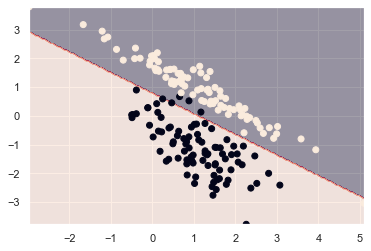

In [162]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

[0.4447856422747295, 0.4437375675765605, 0.44270116095296114, 0.44167625646096936, 0.44066269049471524, 0.43966030176160137, 0.43866893125824524, 0.4376884222462094, 0.43671862022754604, 0.43575937292018113, 0.4348105302331634, 0.4338719442417986, 0.43294346916269405, 0.432024961328734, 0.43111627916400436, 0.4302172831586892, 0.429327835843954, 0.42844780176683683, 0.4275770474651618, 0.42671544144249085, 0.4258628541431303, 0.4250191579272062, 0.4241842270458201, 0.423357937616301, 0.4225401675975638, 0.4217307967655858, 0.42092970668901286, 0.4201367807049045, 0.41935190389462795, 0.41857496305990954, 0.4178058466990525, 0.41704444498332827, 0.416290649733549, 0.4155443543968275, 0.41480545402353075, 0.4140738452444346, 0.41334942624808113, 0.4126320967583477, 0.4119217580122289, 0.4112183127378376, 0.41052166513262733, 0.4098317208418398, 0.4091483869371807, 0.408471571895726, 0.40780118557906114, 0.40713713921265454, 0.40647934536546887, 0.4058277179298088, 0.4051821721014089, 0.4

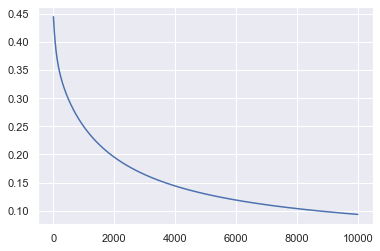

In [163]:
print(model.lh)
plt.plot(model.lh)

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [192]:
my_accuracy_linear = list()
my_accuracy_poly = list()
my_accuracy_rbf = list()

my_auc_roc_linear = list()
my_auc_roc_poly = list()
my_auc_roc_rbf = list()

my_f1_linear = list()
my_f1_poly = list()
my_f1_rbf = list()


In [193]:
from sklearn.svm import SVC


def svm_kernels(features_train, features_valid, target_train, target_valid, kernel):
    for iter in np.linspace(0.0005, 5, 1000):
        model = SVC(kernel=kernel, C=iter)
        model.fit(features_train, target_train)
        predicted = model.predict(features_valid)
        if kernel == 'linear':
            my_accuracy_linear.append(accuracy_score(target_valid, predicted))
            my_auc_roc_linear.append(roc_auc_score(target_valid, predicted))
            my_f1_linear.append(f1_score(target_valid, predicted))
        elif kernel == 'poly':
            my_accuracy_poly.append(accuracy_score(target_valid, predicted))
            my_auc_roc_poly.append(roc_auc_score(target_valid, predicted))
            my_f1_poly.append(f1_score(target_valid, predicted))
        else:
            my_accuracy_rbf.append(accuracy_score(target_valid, predicted))
            my_auc_roc_rbf.append(roc_auc_score(target_valid, predicted))
            my_f1_rbf.append(f1_score(target_valid, predicted))


In [194]:
features_train, features_valid, target_train, target_valid = train_test_split(X, y, test_size=0.25, random_state=12345)

In [195]:
svm_kernels(features_train, features_valid, target_train, target_valid, 'linear')
svm_kernels(features_train, features_valid, target_train, target_valid, 'poly')
svm_kernels(features_train, features_valid, target_train, target_valid, 'rbf')

In [196]:
print((my_accuracy_linear))
print((my_accuracy_poly))
print((my_accuracy_rbf))

[0.9555555555555556]
[0.9777777777777777]
[0.9777777777777777]


Accuracy


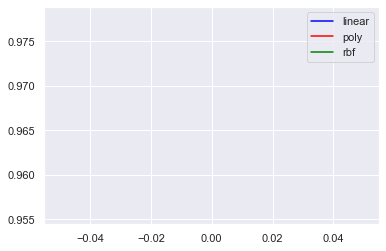

AUC ROC


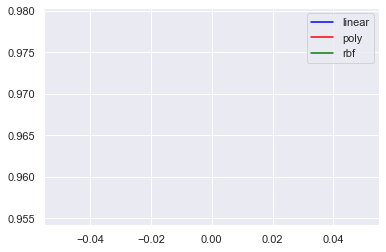

F1


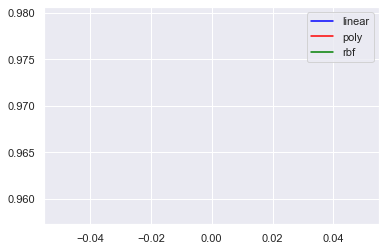

In [197]:
print("Accuracy")
plt.plot(my_accuracy_linear,label='linear', color = 'blue')
plt.plot(my_accuracy_poly,label='poly', color = 'red')
plt.plot(my_accuracy_rbf,label='rbf', color = 'green')
plt.legend()
plt.show()
print('AUC ROC')
plt.plot(my_auc_roc_linear,label='linear', color = 'blue')
plt.plot(my_auc_roc_poly,label='poly',color = 'red')
plt.plot(my_auc_roc_rbf,label='rbf',color = 'green')
plt.legend()
plt.show()
print('F1')
plt.plot(my_f1_linear,label='linear', color = 'blue')
plt.plot(my_f1_poly,label='poly',color = 'red')
plt.plot(my_f1_rbf,label='rbf',color = 'green')
plt.legend()
plt.show()

## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors:
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively

    sample data may look like:

    <center>
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr>
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td>
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td>
        <tr><td> ... </td><td> ... </td><td>
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>
    </table>
</center>

2. Preprocess (tokenize and clean) the dataset
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

Chosen authors: Gogol, Herzen, Turgenev, Tolstoy, Pushkin and Blok

In [170]:
import glob
import pandas as pd

In [171]:
fold = 'C:/Users/Александр/DataspellProjects/HSE-ML/third_hw/datasets/prose'
my_authors = ['Gogol', 'Herzen', 'Turgenev', 'Tolstoy', 'Pushkin', 'Blok']

features_sent = []
for author in my_authors:
    tmp_sent = []
    for filename in glob.glob(fold + '/' + author + '/*.txt'):
        data_text = []
        with open(filename, 'r', encoding="utf-8") as file:
            data_text = file.read()
        data_text = data_text.replace('\n', ' ').split('.')
        # for i in range(len(data_text)):
        #     if len(data_text[i]) <= 15:
        #         data_text.pop(i)
        data_text = [data_text[i] for i in range(len(data_text)) if len(data_text[i]) >= 15] # конечно из-за того, что list comr удобно откинуть длину 15, но будет списком
        tmp_sent.extend(data_text)
    features_sent.append(tmp_sent)
display(pd.Series(my_authors), pd.Series(features_sent))

0       Gogol
1      Herzen
2    Turgenev
3     Tolstoy
4     Pushkin
5        Blok
dtype: object

0    [Николай Васильевич Гоголь  Рим  Отрывок     П...
1    [СЫНУ МОЕМУ АЛЕКСАНДРУ        Друг мой Саша,  ...
2    [ Иван Сергеевич Тургенев Стихотворения в проз...
3    [ Толстой РУБКА ЛЕСА,  РАССКАЗ ЮНКЕРА,      В ...
4    [Александр Пушкин РОСЛАВЛЕВ Читая «Рославлева»...
5    [Сказка о той, которая не поймет ее     Уже ра...
dtype: object

In [191]:
#"5k : 15k : 8k : 11k : 20k : 3k"

tmp = 5 + 15 + 8 + 11 + 20 + 3
k = 100 / tmp

def randomly_choose(element, koef):
    element = pd.Series(element)
    return element.sample(frac=koef * k / 100, replace=True, random_state=12345)


features_sent[0] = randomly_choose(features_sent[0], 5)
features_sent[1] = randomly_choose(features_sent[1], 15)
features_sent[2] = randomly_choose(features_sent[2], 8)
features_sent[3] = randomly_choose(features_sent[3], 11)
features_sent[4] = randomly_choose(features_sent[4], 20)
features_sent[5] = randomly_choose(features_sent[5], 3)


display(pd.Series(my_authors), pd.Series(features_sent))

0       Gogol
1      Herzen
2    Turgenev
3     Tolstoy
4     Pushkin
5        Blok
dtype: object

0    14465     Юрисконсульт отвечал на это изображе...
1    5605                                   дочь и ...
2    12655     – Ну, поцелуй же меня по крайней мер...
3    73728     Так думали те, которые видели их в ц...
4    8761     «Она в саду, – отвечала старушка, – п...
5    382        Вдруг над крышей высокого дома, в с...
dtype: object

In [173]:
from sklearn.utils import shuffle
import random

data = pd.DataFrame([], columns=['sentence', 'author'])

# print(features_sent[0])
print()


def creating_data(i, sentence, author):
    tmp_sent_for_each_author = sentence
    tmp_author_for_each_author = list()
    for i in range(len(tmp_sent_for_each_author)):
        tmp_author_for_each_author.append(author)
    tmp_data_for_each_author = pd.DataFrame()
    tmp_data_for_each_author['sentence'] = list(tmp_sent_for_each_author)
    tmp_data_for_each_author['author'] = tmp_author_for_each_author
    return tmp_data_for_each_author


for i in range(len(my_authors)):
    data = pd.concat(
        [data] + [creating_data(i, features_sent[i], my_authors[i])
                  ])
data = shuffle(data, random_state=42)
data = data.reset_index(drop=True)
display(data)

,sentence,author
0,- Кто-то ехал на ослице в черном платье; он ...,Herzen
1,Оленин уже уехал верхом купаться на Терек,Tolstoy
2,"– Да, вы достигли всех ваших целей, – промолв...",Turgenev
3,В особенности неприятно ей было видеть княжну...,Tolstoy
4,Я выбрал это место с самого начала,Tolstoy
...,...,...
24663,"- Вот возьму тебя колодкой отжучу, не погляжу...",Tolstoy
24664,"И руки у всех были дворянские, белые, большие...",Turgenev
24665,Везде уловлена была эта плывучая округлость л...,Gogol
24666,"– Как же ты послала сказать княжне, что мы н...",Tolstoy


Using seminar 6 code.

In [174]:
import string # for work with strings
import nltk   # Natural Language Toolkit

In [175]:
# get russian stop words
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')

# example of stop words
stop_words[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Александр\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [176]:
word_tokenizer = nltk.WordPunctTokenizer()

In [177]:
dates = [str(x) for x in np.arange(1900, 2022)]
def process_data(data):
    words = []
    for sentence in data['sentence']:
        # collect nlabels of news
        sentence_lower = sentence.lower() # convert words in a text to lower case
        tokens = word_tokenizer.tokenize(sentence_lower) # splits the text into tokens (words)
        # remove punct and stop words from tokens
        tokens = [word for word in tokens if (word not in string.punctuation and word not in stop_words and word not in dates)]
        words.append(tokens) # collect the text tokens
    return words

In [178]:
words = process_data(data)
display(words)
print()
words[:3]
print("Tokens: ", words[:5])

[['ехал', 'ослице', 'черном', 'платье', 'спускал', 'глаз', 'это', 'монах'],
 ['оленин', 'уехал', 'верхом', 'купаться', 'терек'],
 ['–', 'достигли', 'ваших', 'целей', '–', 'промолвил', 'федор', 'иваныч'],
 ['особенности',
  'неприятно',
  'видеть',
  'княжну',
  'варвару',
  'прощавшую',
  'те',
  'удобства',
  'которыми',
  'пользовалась'],
 ['выбрал', 'это', 'место', 'самого', 'начала'],
 ['хлеба', 'ради', 'христа', 'хлеба'],
 ['–',
  'такое',
  'другого',
  'оно',
  'старое',
  'гадкое',
  'принуждена',
  'надевать',
  'это',
  'платье',
  'каждый',
  'день',
  '…',
  '…',
  'приходите',
  '…',
  'разлюбишь',
  'видя',
  'замарашкой',
  '–',
  'помилуй',
  'ирина',
  'говоришь',
  'платье',
  'это',
  'премилое',
  '…',
  'оно',
  'дорого',
  'первый',
  'нем',
  'видел'],
 ['наташа', 'петербурге'],
 ['любил',
  'помечтать',
  'деревенская',
  'жизнь',
  'развила',
  'нем',
  'способность'],
 ['прошло',
  'пять',
  'лет',
  'тех',
  'пор',
  'принял',
  'должность',
  'старшего',
  '


Tokens:  [['ехал', 'ослице', 'черном', 'платье', 'спускал', 'глаз', 'это', 'монах'], ['оленин', 'уехал', 'верхом', 'купаться', 'терек'], ['–', 'достигли', 'ваших', 'целей', '–', 'промолвил', 'федор', 'иваныч'], ['особенности', 'неприятно', 'видеть', 'княжну', 'варвару', 'прощавшую', 'те', 'удобства', 'которыми', 'пользовалась'], ['выбрал', 'это', 'место', 'самого', 'начала']]


In [179]:
! pip install pymorphy2

In [180]:
%%time
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

morph_word = []
for aword in words:
    # aword_norm = morph.parse(aword)[0].normal_form
    morph_word.append([morph.parse(word)[0].normal_form for word in aword])
    # print("Before: %s, After: %s" % (aword, aword_norm))
morph_word[:5]

CPU times: total: 37.7 s
Wall time: 38.4 s


[['ехать', 'ослица', 'чёрный', 'платье', 'спускать', 'глаз', 'это', 'монах'],
 ['оленина', 'уехать', 'верхом', 'купаться', 'терек'],
 ['–', 'достигнуть', 'ваш', 'цель', '–', 'промолвить', 'фёдор', 'иванович'],
 ['особенность',
  'неприятно',
  'видеть',
  'княжна',
  'варвар',
  'прощать',
  'тот',
  'удобство',
  'который',
  'пользоваться'],
 ['выбрать', 'это', 'место', 'сам', 'начало']]

In [181]:
upgrade_morph_sent = []
tmp_morph_sent = str()
for word in morph_word:
    tmp_morph_sent = ''
    for morph_1 in word:
        tmp_morph_sent += morph_1 + ' '
    upgrade_morph_sent.append(tmp_morph_sent)
data['morph_sentence'] = upgrade_morph_sent
display(data)

,sentence,author,morph_sentence
0,- Кто-то ехал на ослице в черном платье; он ...,Herzen,ехать ослица чёрный платье спускать глаз это м...
1,Оленин уже уехал верхом купаться на Терек,Tolstoy,оленина уехать верхом купаться терек
2,"– Да, вы достигли всех ваших целей, – промолв...",Turgenev,– достигнуть ваш цель – промолвить фёдор ивано...
3,В особенности неприятно ей было видеть княжну...,Tolstoy,особенность неприятно видеть княжна варвар про...
4,Я выбрал это место с самого начала,Tolstoy,выбрать это место сам начало
...,...,...,...
24663,"- Вот возьму тебя колодкой отжучу, не погляжу...",Tolstoy,взять колодка отжучить поглядеть твой фрак узн...
24664,"И руки у всех были дворянские, белые, большие...",Turgenev,рука дворянский белые больший крепкий слоновый...
24665,Везде уловлена была эта плывучая округлость л...,Gogol,везде уловить этот плывучий округлость линия з...
24666,"– Как же ты послала сказать княжне, что мы н...",Tolstoy,– послать сказать княжна поехать – потерять го...


In [182]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features = 50)
vectorizer.fit(list(data['morph_sentence']))

# The top 10 words
vectorizer.get_feature_names()[:10]

C:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['бог',
 'ваш',
 'весь',
 'видеть',
 'время',
 'выйти',
 'глаз',
 'говорить',
 'год',
 'голова']

In [183]:
bag =  vectorizer.transform(data['morph_sentence'])
bag.todense()[:5]



matrix([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 0]], dtype=int64)

In [184]:
#calc tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
# Fit TF-IDF on train texts
vectorizer = TfidfVectorizer(max_features = 100) # select the top 100 words
vectorizer.fit(data['morph_sentence'])

# The top 10 words
vectorizer.get_feature_names()[:10]

['андрей',
 'бог',
 'больший',
 'быть',
 'ваш',
 'весь',
 'взять',
 'видеть',
 'время',
 'всякий']

In [185]:
td_idf_sentences = vectorizer.transform(data['morph_sentence'])
td_idf_sentences.todense()[:5]

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.56974565, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.70054262, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn)

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrixfor train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn)
* make conclusions about the performance of your models


In [186]:
# your code here
two = ['Gogol']
new_data = data.query('author in ["Pushkin", "Herzen"]')
display(new_data)

,sentence,author,morph_sentence
0,- Кто-то ехал на ослице в черном платье; он ...,Herzen,ехать ослица чёрный платье спускать глаз это м...
5,"Хлеба, ради Христа, хлеба",Pushkin,хлеб ради христос хлеб
9,"Прошло пять лет с тех пор, как он принял на...",Herzen,пройти пять год тот пора принять должность ста...
10,Гляжу: Савельич лежит в ногах у Пугачева,Pushkin,глядеть савельич лежать нога пугачёв
14,– Освобождение Уфы и Яицкого городка,Pushkin,– освобождение уфа яицкий городок
...,...,...,...
24649,Шайка выступила из крепости в порядке,Pushkin,шайка выступить крепость порядок
24651,Против этого и восстал социализм; он осмелилс...,Herzen,против восстать социализм осмелиться сказать г...
24656,– Отступление Пугачева,Pushkin,– отступление пугачёв
24660,– Сражение под Татищевой,Pushkin,– сражение татищева


In [187]:
display(new_data['author'].value_counts(normalize=True))

Pushkin    0.592585
Herzen     0.407415
Name: author, dtype: float64

In [188]:
features_train, features_valid, target_train, target_valid = train_test_split(new_data['morph_sentence'], new_data['author'], stratify=new_data['author'], test_size=0.3, random_state=12345)

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve

In [189]:
# your code here

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (use sklearn)

In [190]:
# your code here